In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import multivariate_normal
%matplotlib inline
from random import randint
from tqdm import tqdm_notebook
from operator import mul

/Users/aleksandramalkova/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## * example of the sequential learning of the density vector, Section 2.4

computing initial vector of densities

In [3]:
def init_condition(I,L,n_max):
    dx=L/I
    n0=np.zeros(I)
    for i in range(I):
        #Shock moving backward  
        if i+1<3./4*I:
            n0[i]= 4./10*n_max
        else:
            n0[i]= 8./10*n_max
    print n0
#         #Shock moving forward  
#         if i+1<3/4*I:
#             n0[i]= 2/10*n_max
#         else:
#             n0[i]= 6/10*n_max

#         #Rarefaction waves 
#         if i+1<3/4*I:
#             n0[i]= 7/10*n_max
#         else:
#             n0[i]= 3/10*n_max
    return n0


calculation of the speed according to the density vector values (triangular FD) 

In [4]:
def calcn_V(n,V_max,n_max):
    I = len(n)
    V = np.zeros(I)
    for i in range(I):
        if n[i] <= n_max/3.:
            V[i] = V_max
        else:
            V[i] = (n_max/n[i]-1)*V_max/2.
        rho_crit = n_max/3.
        flux_max = rho_crit*V_max
        
    return V, rho_crit, flux_max

propagation of the next state

In [5]:
def calcn_propagation_1D(n0,dt,dx,flux_inflow,flux_outflow,V_max,n_max):
    I=len(n0)
    n=np.zeros(I)
    lam=dt/dx
    
#     print 'length ', len(n)
    
    V0,rho_crit,flux_max = calcn_V(n0,V_max,n_max) # remove or not
    
    for i in range(1,I-1):
        gi_next = min(V0[i]*n0[i], V0[i+1]*n0[i+1])*(n0[i] <= n0[i+1]) \
                +V0[i]*n0[i]*(n0[i+1] < n0[i])*(n0[i] <= rho_crit) \
                +flux_max*(n0[i+1] < rho_crit)*(rho_crit < n0[i]) \
                +V0[i+1]*n0[i+1]*(rho_crit <= n0[i+1])*(n0[i+1] < n0[i])
                
        gi_prev = min(V0[i-1]*n0[i-1], V0[i]*n0[i])*(n0[i-1] <= n0[i]) \
                +V0[i-1]*n0[i-1]*(n0[i] < n0[i-1])*(n0[i-1] <= rho_crit) \
                +flux_max*(n0[i] < rho_crit)*(rho_crit < n0[i-1]) \
                +V0[i]*n0[i]*(rho_crit <= n0[i])*(n0[i] < n0[i-1])
                
        n[i] = n0[i] - lam*(gi_next - gi_prev)
    
#     print 'prop inside', n
    
    # Entering Cell
    g1_next = min(V0[1]*n0[0], V0[1]*n0[1])*(n0[0] <= n0[1]) \
            +V0[0]*n0[0]*(n0[1] < n0[0])*(n0[0] <= rho_crit) \
            +flux_max*(n0[1] < rho_crit)*(rho_crit < n0[0]) \
            +V0[1]*n0[1]*(rho_crit <= n0[1])*(n0[1] < n0[0])
    g1_prev = min(V0[0]*n0[0], flux_inflow)*(n0[0] > rho_crit) \
        +flux_inflow*(n0[0] <= rho_crit)
    n[0]=n0[0]-lam*( g1_next - g1_prev )
    
    #Leaving Cell
    gI_next = min(V0[I-1]*n0[I-1],flux_outflow)*(n0[I-1] <= rho_crit) \
        +V0[I-1]*n0[I-1]*(n0[I-1] > rho_crit)
    gI_prev = min(V0[I-2]*n0[I-2], V0[I-1]*n0[I-1])*(n0[I-2] <= n0[I-1]) \
            +V0[I-2]*n0[I-2]*(n0[I-1] < n0[I-2])*(n0[I-2] <= rho_crit) \
            +flux_max*(n0[I-1] < rho_crit)*(rho_crit < n0[I-2]) \
            +V0[I-1]*n0[I-1]*(rho_crit <= n0[I-1])*(n0[I-1] < n0[I-2])
    n[I-1]=n0[I-1]-lam*( gI_next - gI_prev )
    
#     print 'propagation ', n
    
    return n

main code

In [12]:
def script_LWR_first():
    I=100
    L=1. # Length of the Road
    V_max=1. # Speed limit
    n_max=1. # Maximum density
    cfl=0.5
    
    dx=L/I # Space Discretisation

    n0 = init_condition(I,L,n_max) # Initial condition for 
    print 'init cond ', n0
    plt.plot(n0)
    init_V = calcn_V(n0, V_max, n_max) # Define the Fundam considered within this function

    flux_inflow, flux_outflow = 0.1, 0.2 # Set the inflow condition and allowed outflow
    
    dt=cfl*dx/V_max
    t=0
    t_max=2 # Final Time of the simulation
    n=n0
    k = 1
    while t < t_max:
        n = calcn_propagation_1D(n,dt,dx,flux_inflow,flux_outflow,V_max,n_max)
#         print n
#         print n
#         plt.figure()
        plt.xlabel('number of a cell, i')
        plt.ylabel('density value')
        k += 1
        if k%21==0:
            plt.plot(n)
        t = t + dt
        

[0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4
 0.4 0.4 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8]


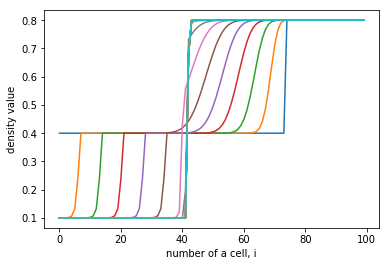

In [13]:
script_LWR_first()

### start of the code


calculation of the flow by density vector (parabolic FD)

In [14]:
def calcn_flow_parab(n, flux_max,rho_crit, n_max):
    I = len(n)
    q = np.zeros(I)
    rho_max = 2*rho_crit  
    for i in range(I):
        q[i] = n[i]*(1-n[i]/rho_max)*4*flux_max/rho_max
    return q

calculation of the flow by density vector (triangular FD)

In [15]:
def calcn_flow(n,flux_max,rho_crit,n_max):
    I = len(n)
    q = np.zeros(I)
    for i in range(I):
        if n[i] < rho_crit:
            q[i] = flux_max/rho_crit * n[i]
        else:
            q[i] = flux_max*(n_max - n[i])/(n_max - rho_crit)
    return q

calculation of the next state 

In [16]:
def calcn_propagation(n0,lam,flux_inflow,flux_outflow,rho_crit,n_max,flux_max, compare_models):
    I=len(n0)
    n=np.zeros(I)

    rho_max = 2*rho_crit 

    if compare_models:
        q0 = calcn_flow_parab(n0,flux_max,rho_crit,n_max)
    else:
        q0 = calcn_flow(n0,flux_max,rho_crit,n_max)
    for i in range(1,I-1):
        gi_next = min(q0[i], q0[i+1])*(n0[i] <= n0[i+1]) \
                +q0[i]*(n0[i+1] < n0[i])*(n0[i] <= rho_crit) \
                +flux_max*(n0[i+1] < rho_crit)*(rho_crit < n0[i]) \
                +q0[i+1]*(rho_crit <= n0[i+1])*(n0[i+1] < n0[i])
                
        gi_prev = min(q0[i-1], q0[i])*(n0[i-1] <= n0[i]) \
                +q0[i-1]*(n0[i] < n0[i-1])*(n0[i-1] <= rho_crit) \
                +flux_max*(n0[i] < rho_crit)*(rho_crit < n0[i-1]) \
                +q0[i]*(rho_crit <= n0[i])*(n0[i] < n0[i-1])
                
        n[i] = n0[i] - lam*(gi_next - gi_prev)
    
    
    # Entering Cell
    g1_next = min(q0[0], q0[1])*(n0[0] <= n0[1]) \
            +q0[0]*(n0[1] < n0[0])*(n0[0] <= rho_crit) \
            +flux_max*(n0[1] < rho_crit)*(rho_crit < n0[0]) \
            +q0[1]*(rho_crit <= n0[1])*(n0[1] < n0[0])
    g1_prev = min(q0[0], flux_inflow)*(n0[0] > rho_crit) \
        +flux_inflow*(n0[0] <= rho_crit)
    n[0]=n0[0]-lam*( g1_next - g1_prev )
    
    
    #Leaving Cell
    gI_next = min(q0[I-1],flux_outflow)*(n0[I-1] <= rho_crit) \
        +q0[I-1]*(n0[I-1] > rho_crit)
    gI_prev = min(q0[I-2], q0[I-1])*(n0[I-2] <= n0[I-1]) \
            +q0[I-2]*(n0[I-1] < n0[I-2])*(n0[I-2] <= rho_crit) \
            +flux_max*(n0[I-1] < rho_crit)*(rho_crit < n0[I-2]) \
            +q0[I-2]*(rho_crit <= n0[I-1])*(n0[I-1] < n0[I-2])
    n[I-1]=n0[I-1]-lam*( gI_next - gI_prev )
        
    return n

step 1 of the algorithm: calculation of the indices

In [18]:
def resample(weight, N): 
    # w - normalized weights, N - number of particles
    k = np.zeros(N)
    for i in range (N):
        rndm = np.random.multinomial(1, weight, size=1, )[0]
        k[i] = np.where(rndm==1)[0][0] #take the index of vector 
    return k

In [19]:
def Calman_recursion(f_phi, W, V, H, y): #f_phi, W, V, H[t+1], y[t+1]
    mu_f = f_phi #dimension R^k (~ nimber of existed elements in vector y)
    C_f = W # dimension R^(M*M)
    matrix = reduce(np.dot, [H, C_f, H.T]) + V
    K = np.dot(np.dot(C_f,H.T), matrix.I)
    mu[t+1] = mu_f + np.dot(K, y - np.dot(H,mu_f))
    C[t+1] = np.dot(np.eye(M) - np.dot(K, H),C_f)
    return mu[t+1], C[t+1]

calculation of the parameters of the Normal distribution to sample new hidden densities vector

In [20]:
def Calman_recursion_paper(f_phi, y, v, w, M): 
    
    mu_f = f_phi 
    mu = np.zeros(M)
    H = np.zeros((2, M))
    H[0,0] = 1
    H[1, M-1] = 1
    K = np.zeros((M, 2))
    K[0,0] = w/(w+v)
    K[M-1,1] = w/(w+v)
    
    C = w * np.eye(M)
    C[0,0] = C[0,0] * v/(w+v)
    C[M-1,M-1] = C[M-1,M-1] * v/(w+v)
    mu = mu_f

    mu[0] = mu[0] + w/(w+v)*(y[0]-mu_f[0])
    mu[M-1] = mu[M-1] + w/(w+v)*(y[1]-mu_f[M-1]) 
    var_mtrx = np.eye(2)*(v+w)

    return mu, C, var_mtrx 

find weighted quantiles

In [21]:
def find_quantiles(param, weights):
    # to make zip array (by pairs weight - value for the parameter)  - sorted array

    global combined_res
    global t
    param = param[:,0,0]
    param = np.array(param)
    combined = np.vstack((param, weights)).T
    combined = combined[np.argsort(combined[:,0])] #ascent by the value

    combined_res[t] = combined

    result = [0,0]
    summ  = 0.
    kk=0

    while summ < 0.05:
        summ += combined[kk,1]
        kk += 1
    result[0] = combined[kk,0]
    
    summ  = 0.
    kk=0
    while summ < 0.95:
        summ += combined[kk,1]
        kk += 1

    result[1] = combined[kk-1,0]
    return result[0], result[1]

computing particle weights and new vector z_t propagation

In [22]:
def comp_weights_propagate(theta, phi, y, v, w, N, M): # y[t+1],  should be given; for each time step t

    theta_new = np.zeros([N, 1, M])
    mu = np.zeros([N, 1, M])
    C = np.zeros([N, M, M])
    vect_theta = np.zeros(M)
    v_f = 25.
    from scipy.stats import norm
    regul = np.zeros(N)
    weight = np.zeros(N)
    weightss = np.zeros(N)
    for i in range(N):

        f_phi = theta[i][0]

        mu[i], C[i], var_mtrx = Calman_recursion_paper(f_phi, y, v, w, M)
        weight[i] = multivariate_normal.pdf(y,mean=[f_phi[0], f_phi[M-1]], cov=var_mtrx)
        regul[i] = norm.pdf(phi[i][0][0]/phi[i][0][1]/300., v_f, 5.)
    sum_w = np.sum(weight)/N
    bayes_f = sum_w/N
    sum_w = np.sum(np.dot(weight, regul.T))
    for i in range(N): 
        weight[i] = weight[i]*regul[i]/sum_w
    lower, upper = find_quantiles(phi, weight)
    
    k = resample(weight, N)
    for i in range(N):
        indexx = int(k[i])
        while True:

            vect_theta = np.random.multivariate_normal(mean=mu[indexx][0], cov=C[indexx])
            sum_neg = sum(g < 0 for g in vect_theta)
            sum_big = sum(g > 0.15 for g in vect_theta)
            if (sum_neg == 0)&(sum_big == 0):
                break
        theta_new[i][0] = vect_theta
    result = 0.

    result = np.dot(phi[:,0,0], weight.T)
    for i in range(N):
        rndm_ind = randint(0, N-1)
        indexx = int(k[rndm_ind])
        eps = 2
        phi[i][0][0] = np.random.uniform(low = phi[indexx][0][0] - eps, high=phi[indexx][0][0] + eps, size=1) 
        
    
    return theta_new, phi, result, bayes_f, lower, upper

reading the data

In [3]:
#reading the data
tmp = pd.read_csv('24-03-2015_agg_by_lanes_new3.csv') # 5min aggregation day with acc
# tmp = pd.read_csv('14-04-2015_5mins.csv') # day without acc



In [4]:
tmp.head()

,Unnamed: 0,date,sensor pair,occupancy,flow,sum_speed,speed,time,day_week,density
0,0,2015-03-24 00:00:00,0.0,1.868333,132.0,1058.0,96.181818,00:00:00,1,0.003114
1,1,2015-03-24 00:05:00,0.0,1.900000,24.0,232.0,116.000000,00:05:00,1,0.003167
2,2,2015-03-24 00:10:00,0.0,1.373636,144.0,1214.0,101.166667,00:10:00,1,0.002289
3,3,2015-03-24 00:15:00,0.0,2.354286,132.0,1132.0,102.909091,00:15:00,1,0.003924
4,4,2015-03-24 00:20:00,0.0,2.311429,156.0,1290.0,99.230769,00:20:00,1,0.003852


In [5]:
len(tmp)/3

287

extracting values and putting into right format

In [25]:
flux = np.zeros((tmp[tmp['sensor pair']==0.].shape[0],2))
flux[:,0] = tmp['flow'][tmp['sensor pair']==0.]/12./300
flux[:,1] = tmp['flow'][tmp['sensor pair']==2.]/12./300


y = np.zeros((tmp[tmp['sensor pair']==0.].shape[0],2))
y[:,0] = tmp['density'][tmp['sensor pair']==0.]
y[:,1] = tmp['density'][tmp['sensor pair']==2.]


main code

In [40]:
N = 1000 # number of particles 10000 - optimal, but running time ~1hour
M = 3 # number of cells

v = 0.00002 #errors
w = 0.00001

compare_models = False # True for using parab diagram, False for triangular

V = v * np.eye(2)
W = w * np.eye(M)

theta = np.zeros([N, 1, M])
theta_new = np.zeros([N, 1, M])
# print theta

I=M # number of cells
L=900. # Length of the Road
# V_max=1. # Speed limit
n_max=0.17 # Maximum density = 1/6 meters^-1
cfl=0.5
t=0
t_max= 286 #10 #286  value for all day

phi = np.zeros([N, 1, 3]) #for N particles flux_max, rho_crit, n_max
phi_result = np.zeros([t_max-1, 1, 3]) #for all time flux_max, rho_crit, n_max
weight = np.zeros(N)
bayes_f = np.zeros(t_max)
lower = np.zeros(t_max-1) #value for quantiles
upper = np.zeros(t_max-1) #
combined_res = np.zeros([t_max-1, N, 2])

n0 = np.linspace(y[0][0], y[0][1], I)# Initial condition : as approximation between boundary conditions

# print 'initial value n0', n0 

dx=L/I # Space Discretisation
dt = 300 #seconds, if dt = 1 hour
lam=1/dx/30

for i in range(N):
    phi[i][0][0] = np.random.uniform(low=120.0, high=130.0, size=1) # different values of initial flux_max
    phi[i][0][1] =  0.017 # rho_crit without changes
    phi[i][0][2] =  0.16# maximum value for density

    flux_inflow, flux_outflow = flux[t][0], flux[t][1] # Set the inflow condition, 
                                                #allowed outflow - for each t data from the history
    
    # receive f_phi(theta_0)
    theta[i][0] = calcn_propagation(n0,lam,flux_inflow,flux_outflow, phi[i][0][1], phi[i][0][2],phi[i][0][0], compare_models) 
    

print 'y[t]', y[t]    

theta_new, phi, result, bayes_f[0], lower[t], upper[t] = comp_weights_propagate(theta, phi, y[t+1], v, w, N, M) # y[t+1], where t = 0
phi_result[t][0][0] = result

result = 0.
print ' '
t =t+1

for t in tqdm_notebook(range(1,t_max-1)):
#     print 'iteration: ', t
    for i in range (N):
        n0 = theta_new[i][0]
#         print ''
        flux_inflow, flux_outflow = flux[t][0], flux[t][1]
        theta[i][0] = calcn_propagation(n0,lam,flux_inflow,flux_outflow, phi[i][0][1], phi[i][0][2],phi[i][0][0], compare_models) 
    theta_new, phi, result, bayes_f[t], lower[t], upper[t] = comp_weights_propagate(theta, phi, y[t+1], v, w, N, M) # y[t+1], where t = 0
    phi_result[t][0][0] = result
    t = t + 1

y[t] [0.01065729 0.        ]
 


received day without accidents, 10000 particles

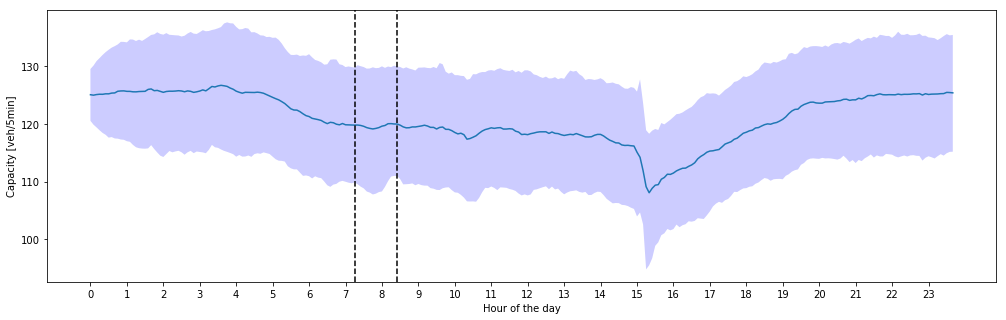

In [128]:
fig = plt.figure(1, figsize=(17, 5))
plt.fill_between(range(t_max-1), lower, upper, facecolor='blue', alpha=.2)
plt.plot(range(t_max-1),phi_result[:,0,0])
# plt.plot(range(t_max-1),median_computed)
plt.axvline(x=87,linestyle = 'dashed', color = 'black')#accident start
plt.axvline(x=101,linestyle = 'dashed', color = 'black')#finish
plt.xticks(np.arange(0, 286, 12.0), range(24))
plt.ylabel('Capacity [veh/5min]')
plt.xlabel('Hour of the day')
plt.show()

received day with accident, 10000 particles

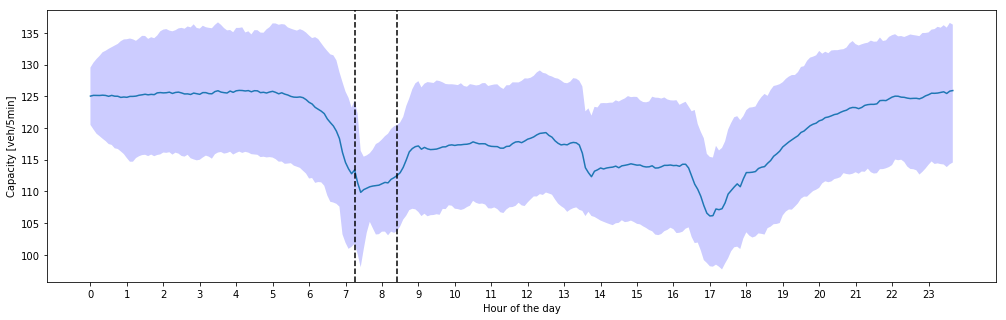

In [119]:
fig = plt.figure(1, figsize=(17, 5))
plt.fill_between(range(t_max-1), lower, upper, facecolor='blue', alpha=.2)
plt.plot(range(t_max-1),phi_result[:,0,0])
# plt.plot(range(t_max-1),median_computed)
plt.axvline(x=87,linestyle = 'dashed', color = 'black')#accident start
plt.axvline(x=101,linestyle = 'dashed', color = 'black')#finish
plt.xticks(np.arange(0, 286, 12.0), range(24))
plt.ylabel('Capacity [veh/5min]')
plt.xlabel('Hour of the day')
plt.show()

In [114]:
median_computed = np.zeros(t_max-1)
for i in range(t_max-1):
    median_computed[i] = np.dot(combined_res[i,:,0], combined_res[i,:,1].T)

if compare_models == True

In [329]:
parabolistic = bayes_f

if compare_models == False

In [332]:
triangular = bayes_f

In [324]:
print parabolistic
print triangular

[4.17253480e+00 2.54629596e+00 2.73949551e+00 1.85281106e+00
 2.24596689e+00 2.34561449e+00 2.42989366e+00 1.95190559e+00
 2.01017047e+00 2.05358517e+00 2.28778458e+00 2.03808283e+00
 2.32892529e+00 2.53373093e+00 2.37223523e+00 3.45889742e+00
 1.92279577e+00 2.36768409e+00 1.86083400e+00 2.19045763e+00
 2.55104281e+00 2.09372903e+00 2.19791853e+00 2.22050192e+00
 2.26721337e+00 2.15650732e+00 2.11697756e+00 2.35351690e+00
 2.28009029e+00 2.50179348e+00 2.17387488e+00 2.20977466e+00
 1.98483312e+00 2.39893452e+00 2.46552154e+00 2.45382629e+00
 2.20686101e+00 2.24253523e+00 1.96249643e+00 2.24798292e+00
 1.98287999e+00 2.33749886e+00 2.17708422e+00 2.15683947e+00
 2.29704728e+00 2.12772691e+00 2.11087348e+00 2.29655390e+00
 2.11039951e+00 2.19551947e+00 2.22851105e+00 2.01949843e+00
 2.01480169e+00 2.12318525e+00 1.85119703e+00 2.12856055e+00
 2.11308623e+00 2.06519036e+00 1.84488368e+00 2.10020318e+00
 1.79291553e+00 1.73410460e+00 1.78501518e+00 1.40020459e+00
 1.22802618e+00 1.606838

In [333]:

parabolistic = parabolistic[:-1]
triangular = triangular[:-1]
product_parab = reduce(mul, parabolistic, 1)
product_triang = reduce(mul, triangular, 1)
print product_parab/product_triang

5.06662372084905e-32


Bayes factor

In [327]:
print product_parab/product_triang

5.834902613447734e-32
